pysm3 implements smallscale/high-ell models for thermal dust (d9, d10) and synchrotron (s4, s5) emission. 

Models d9 and s4 are "less complex" and inject small-scale fluctuations in *amplitude parameters only*

Models d10 and s5 *additionally* inject small-scale fluctuations of the *spectral parameters*. 

For the amplitude parameters, all of the new models have a spectral index that changes at some "pivot multipole".  
We need a new class in the power.py module that accepts the pivot multipole, the two different spectral indices, and the amplitudes. It will be similar to power.PowerLaw(), except it should also accept an argument for the pivot multipole (ell_pivot), and the new spectral index (alpha_ss) beyond the pivot multipole. It is also necessary to adjust the power law amplitude to avoid a discontinuity at ell_pivot.

For the spectral parameters, the small scale fluctuations may be a bit more complicated... fgspectra is implemented so that spectral and power parameters are totally separate; I think in these dust beta & temp, synch beta & curvature are also made to depend on ell and some spctral index, so... not sure how to deal with that. Probably let this be the next step once models d9 and s4 look good.

*Author: Jordan E. Shroyer*

*Some code snippets were borrowed or adapted from Giuseppe Puglisi's notebooks on the new PySM3 models: [link here...]*

In [1]:
%cd ../..
from fgspectra.fgspectra.model import Model

import numpy as np
from fgspectra.fgspectra import frequency as fgf
from fgspectra.fgspectra import power as fgp
from fgspectra.fgspectra import cross as fgc

import matplotlib.pyplot as plt
from pathlib import Path
import healpy as hp
import pymaster as nmt
from astropy.io import fits
from scipy.optimize import curve_fit
import pandas as pd

hp.disable_warnings()
%matplotlib inline
plt.style.use("seaborn-v0_8-talk")

import pysm3 as pysm
import pysm3.units as u

/home/js6mu/update_fgspectra


/tmp/ipykernel_4034225/4039301514.py:17: HealpyDeprecationWarning: The disable_warnings function is deprecated and may be removed in a future version.
  hp.disable_warnings()


In [2]:
class PowerLawWithSmallScales(Model):
    r"""Power law

    .. math:: C_\ell = (\ell / \ell_0)^\alpha
    """

    def eval(self, ell=None, alpha=None, ell_0=None, amp=1.0, ell_pivot=None, alpha_ss=None, amp_ss=None):
        """
        Parameters
        ----------
        ell: float or array
            Multipole
        alpha: float or array
            Spectral index.
        ell_0: float
            Reference ell
        amp: float or array
            Amplitude, shape must be compatible with `alpha`.
        ell_pivot: float
            Pivot multipole where spectral index changes to ``small scales`` model
        alpha_smallscales: float or array
            Spectral index beyond ell_pivot, used for pysm3 small scale models
        Returns
        -------
        cl: ndarray
            The last dimension is ell.
            The leading dimensions are the hypothetic dimensions of `alpha`
        """
        alpha = np.array(alpha)[..., np.newaxis]
        amp = np.array(amp)[..., np.newaxis]
        alpha_ss = np.array(alpha_ss)[..., np.newaxis]
        amp_ss = np.array(amp_ss)[..., np.newaxis]

        cell = np.empty(len(ell))
        cell[:ell_pivot] = amp*(ell[:ell_pivot]/ell_0)**alpha
        cell[ell_pivot:] = amp_ss*(ell[ell_pivot:]/ell_0)**alpha_ss

        return cell

We need parameters (spectral indices, amplitudes, etc.) to initialize the models. 

We take spectral indices from the literature. Changing the power law spectral index after the pivot multipole introduces a discontinuity unless you also adjust the amplitude. So, we take power spectra of the PySM3 models and do curve fitting to find the amplitude beyond the pivot multipole.

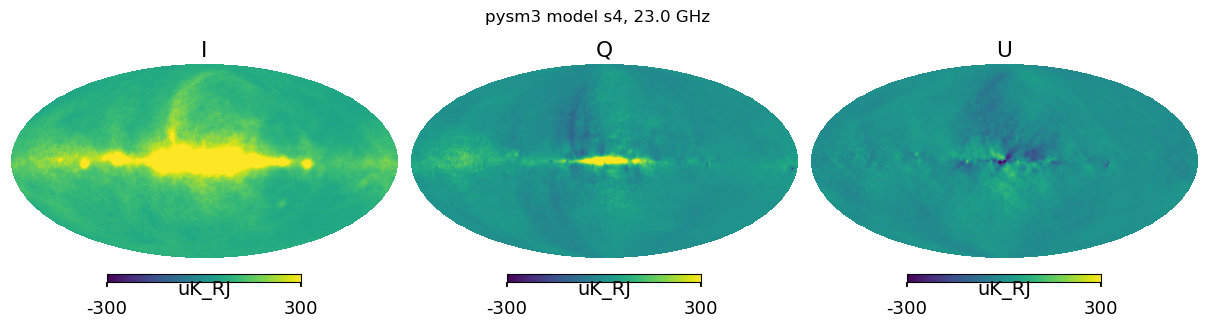

In [3]:
## run pysm3 model for synchrotron
nside=2048
lmax = 3*nside

# model_name = 's4'
# reffreq = 23*u.GHz

model_name = 's4'
reffreq=23*u.GHz

sky = pysm.Sky(nside=nside, preset_strings=[model_name])

spectra_components = ["TT", "EE", "BB","TE"]
comp = "IQU"
components = list(enumerate(comp))

IQU = sky.get_emission(reffreq)

plt.figure(figsize=(12, 3))
for i_pol, pol in components:
    hp.mollview(
        IQU[i_pol],
        title=pol,
        sub=131 + i_pol,
        unit=IQU.unit,
        min=-300,
        max=300,
    )
plt.suptitle(f"pysm3 model {model_name}, {reffreq}")
plt.show()

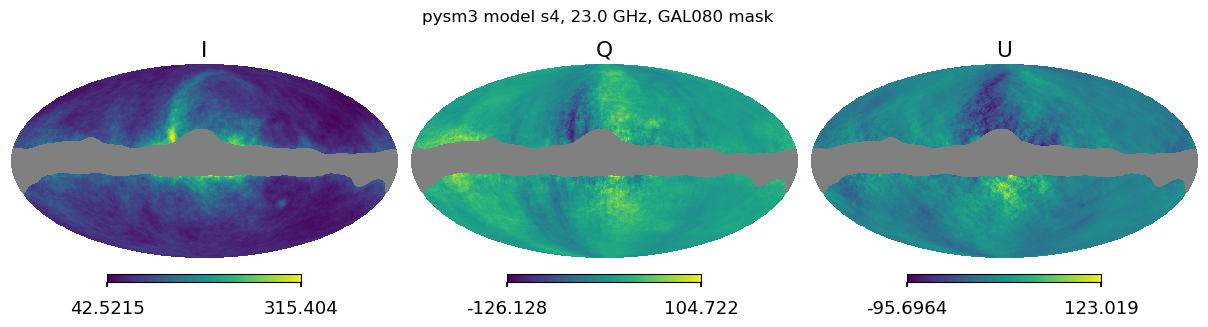

In [4]:
## mask the galactic plane
## TODO: also (instead?) apply an SO sky mask

planck_mask_filename = "giueseppe_examples/data/HFI_Mask_GalPlane-apo2_2048_R2.00.fits"
maskname = "GAL080"
planck_mask = hp.read_map(planck_mask_filename, [maskname])

plt.figure(figsize=(12,3))
IQU_masked = []
for i_pol, pol in components:
    map_masked = hp.ma(IQU[i_pol])
    map_masked.mask = np.logical_not(planck_mask)
    hp.mollview(
        map_masked, 
        title= pol,
        sub=131+i_pol,
    ) 
    IQU_masked.append(map_masked)


plt.suptitle(f"pysm3 model {model_name}, {reffreq}, {maskname} mask")
plt.show()

^^ there may be a better choice of mask here. Reach out to people involved in the pysm3 methods paper...

In [5]:
## get the power spectra for the masked maps
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1,dtype=float )

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

ell, cl_norm, cl = run_anafast(IQU_masked, lmax=lmax)  ## question: what is cl_norm for?

### Fit a double power law with 2 amplitudes and 2 spectral indices

Use the values provided by g.p. for pivotal multipole etc.

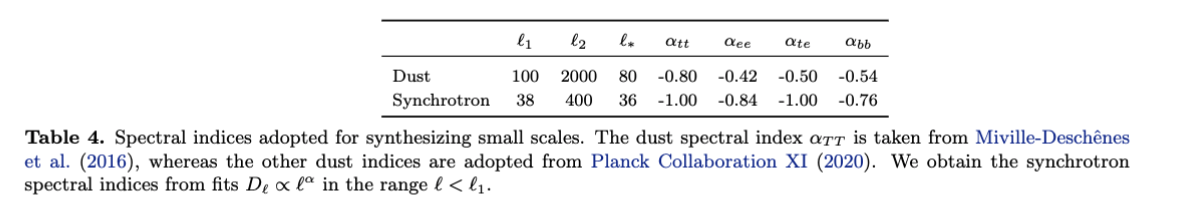

(from draft paper, shared by giuseppe)

question: what is ell1 and is it ever used? Maybe this corresponds to the ell_0 scaling factor in the fgspectra code? maybe the pysm3 methods paper clarifies...

/tmp/ipykernel_4034225/1346450618.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  out = A * ell ** gamma
/tmp/ipykernel_4034225/1346450618.py:3: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


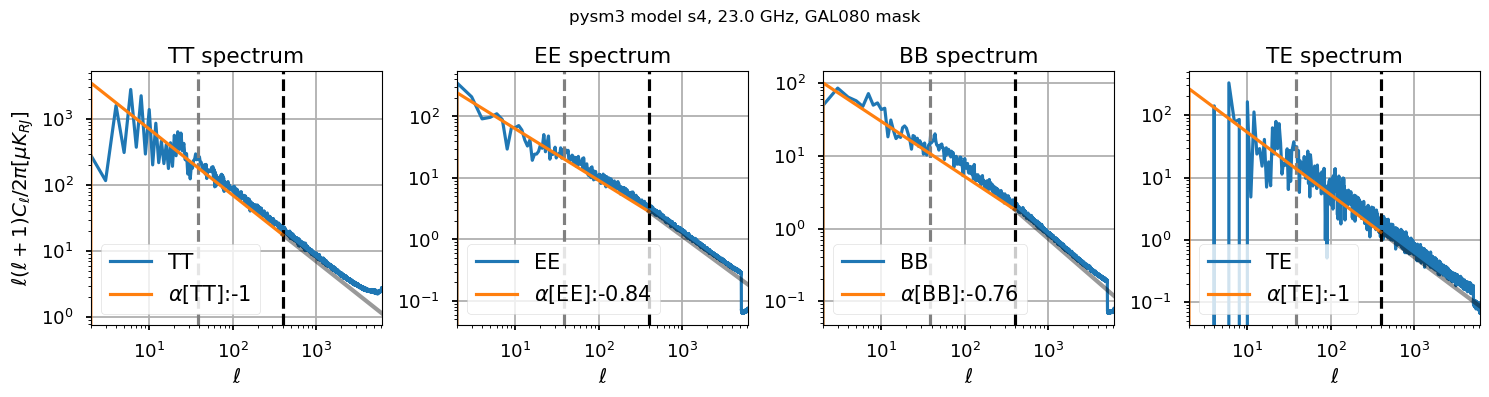

In [10]:
## fit a double power law with 2 amplitudes and 2 spectral indices, save to file
def model(ell, A, gamma):
    out = A * ell ** gamma
    return out

ell_fit_low = {"TT":10, "EE":10, "BB":10,"TE":10}   ## the fit gets weird if you include the very lowest multipoles

ell_fit_high = {"TT":38, "EE":38, "BB":38,"TE":38}  ## synchrotron ell1
ell_pivot =  400  ## synchrotron ell2 from table 
A_fit2, gamma_fit2 = {}, {"TT": -1, "EE":-0.84, "BB"  :-0.76 , "TE":-1} ## synchrotron alpha values from table

# ell_fit_high = {"TT":100, "EE":100, "BB":100,"TE":100}  ## dust ell1
# ell_pivot =  2000  ## dust ell2 from table 
# A_fit2, gamma_fit2 = {}, {"TT": -0.80, "EE":-0.42, "BB"  :-0.54 , "TE":-0.5} ## dust alpha values from table

A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
smallscales =[] 

## dicts to store the params which will be input to fgspectra
A_low, A_high, gamma_low, gamma_high = {}, {}, {}, {}
savedir = "/home/js6mu/update_fgspectra/fgspectra/notebooks/pysm3_params"

# plt.figure(figsize=(25,5))
plt.figure(figsize=(15,4))
for ii, pol in enumerate(spectra_components):
    plt.subplot(141+ii)
    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label=pol )
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")#, label='ell*')
    plt.axvline(ell_pivot, linestyle="--", color="k")#, label='ell2')
    plt.grid()
    plt.title(f"{pol} spectrum" )
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    
    ## fit for ell<ell* (why not ell1?)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])  # fit below ell_fit_high=ell*=36
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)  ## gamma_fit is only used to make the amplitudes match up at ell2; we're using gamma_fit2 (which we don't actually fit for) for our spectral index
    A_fit2[pol] =np.fabs(A_fit[pol])*ell_fit_high[pol]**( gamma_fit[pol ] - gamma_fit2[pol ] )  
    scaling = model(ell[:ell_pivot], A_fit2[pol], gamma_fit2[pol])  ## extrapolate the above model fit from 0-ell2, i.e. ell_pivot
    scaling[:2]=0 
    plt.plot(ell[:ell_pivot], scaling, label=r"$\alpha$"+f"[{pol}]:{gamma_fit2[pol]}")
    smallscales.append(scaling) 
    plt.legend(fontsize=15,loc='lower left')   
    ## update dicts to be saved.
    A_low[pol] = A_fit2[pol]
    gamma_low[pol] = gamma_fit2[pol]
    
# we change the EE and BB power laws so that they don't overlap TT in an unphysical way
for ii, pol in enumerate(spectra_components):
    xdata = np.arange(ell_fit_high[pol], ell.size) # fit above ell_fit_high=ell*=36
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
     
    plt.subplot(141+ii)
    if pol=="TE":
        A_fit2[pol] =A_fit2[pol]* ell_pivot**( gamma_fit2[pol ]- gamma_fit2['TE' ] )
        scaling =  model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TE"])
        plt.plot(ell[ell_pivot:], scaling, linewidth=3, alpha=.4, color='k',)
        smallscales[ii] =np.concatenate([ smallscales[ii], scaling])
        ## update dicts to be saved.
        A_high[pol] = A_fit2[pol]
        gamma_high[pol] = gamma_fit2[pol]
    else: ## set EE, BB small-scale gamma to TT to avoid unphysical overlapping
        A_fit2[pol] =A_fit2[pol]*  ell_pivot**( gamma_fit2[pol ]- gamma_fit2['TT' ] )
        scaling =  model(ell[ell_pivot: ], A_fit2[pol], gamma_fit2["TT"])
        plt.plot(ell[ell_pivot: ], scaling, linewidth=3, alpha=.4, color='k')
        smallscales[ii]=np.concatenate([ smallscales[ii], scaling])
        ## update dicts to be saved.
        A_high[pol] = A_fit2[pol]
        gamma_high[pol] = gamma_fit2["TT"]
    np.savez(f"{savedir}/params{model_name}_reffreq{reffreq}_mask{maskname}.{pol}.npz", A_low=A_low[pol], A_high=A_high[pol], gamma_low=gamma_low[pol], gamma_high=gamma_high[pol], ell_pivot=ell_pivot)
       
plt.subplot(141)
    
plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")

plt.suptitle(f"pysm3 model {model_name}, {reffreq}, {maskname} mask")
plt.tight_layout()
plt.show()
# print(f"pysm3 model {model_name}, {reffreq}, {maskname} mask")

/tmp/ipykernel_4034225/1346450618.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  out = A * ell ** gamma
/tmp/ipykernel_4034225/1346450618.py:3: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


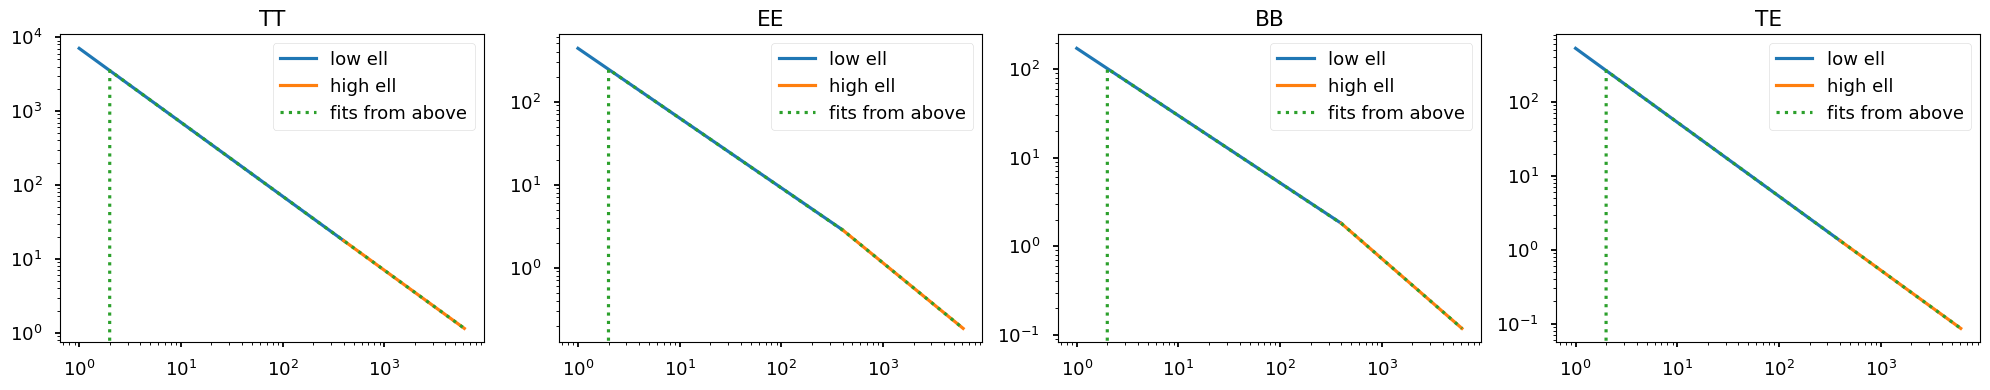

In [11]:
## reconstruct spectra from saved params, compare against the fits above to check that I saved/loaded everything correctly
fig, ax = plt.subplots(1,4,figsize=(20,4))
for ii, pol in enumerate(spectra_components):
    par = np.load(f"{savedir}/params{model_name}_reffreq{reffreq}_mask{maskname}.{pol}.npz")
    ax[ii].loglog(ell[:par['ell_pivot']], model(ell[:par['ell_pivot']], par['A_low'], par['gamma_low']), label='low ell')
    ax[ii].loglog(ell[par['ell_pivot']:], model(ell[par['ell_pivot']:], par['A_high'], par['gamma_high']), label='high ell')
    ax[ii].loglog(ell, smallscales[ii],label='fits from above', linestyle='dotted')
    ax[ii].legend()
    ax[ii].set_title(f"{pol}")
plt.tight_layout()

### Now that we have our parameters, pass them to fgspectra to evaluate the models

In [12]:
# freqs = np.array([23., 150., 353.])
freqs = np.array([reffreq.value])
ells = np.arange(2,3000)

beta_s = -3.1
nu0_s = 23
ell0 = 1 ## what should this actually be??

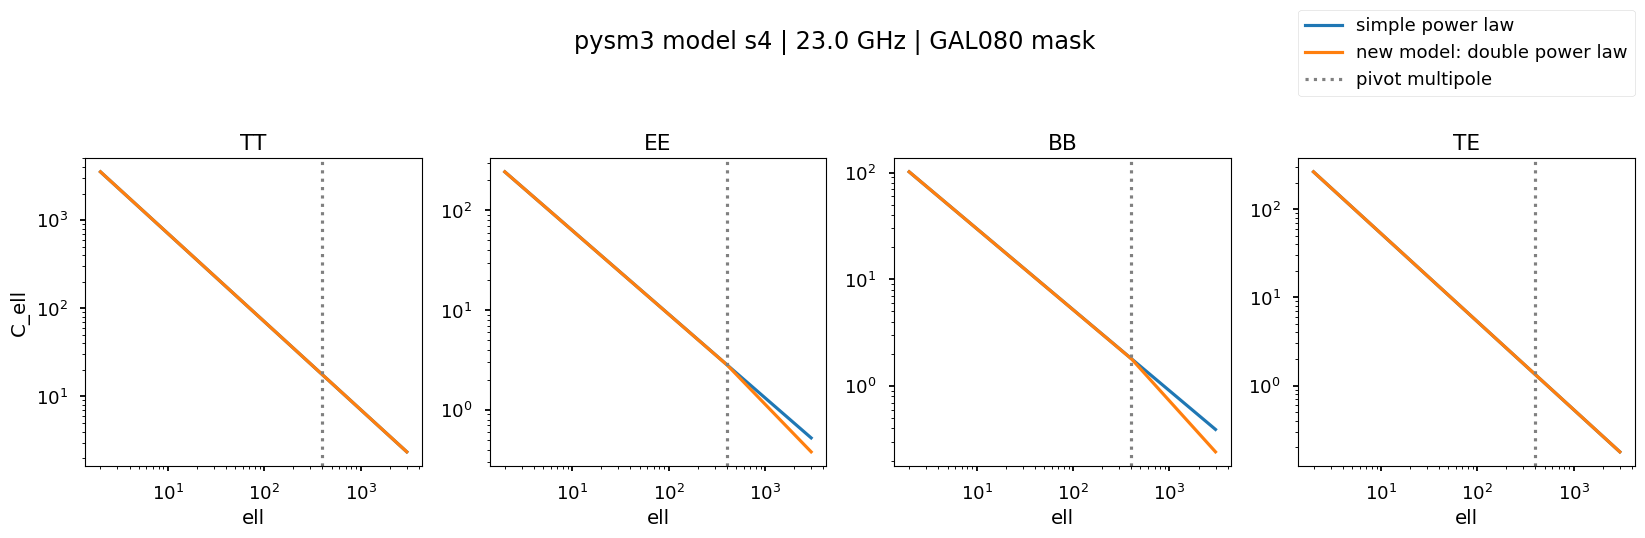

In [19]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
for ii, pol in enumerate(spectra_components):
    par = np.load(f"{savedir}/params{model_name}_reffreq{reffreq}_mask{maskname}.{pol}.npz")
    syncPS = fgp.PowerLaw(ell=ells, alpha=par['gamma_low'],ell_0=1,amp=par['A_low']).eval()
    syncPS_ss = PowerLawWithSmallScales(ell=ells, alpha=par['gamma_low'],ell_0=1,amp=par['A_low'], ell_pivot=par['ell_pivot'], alpha_ss=par['gamma_high'],amp_ss=par['A_high']).eval()

    ax[ii].loglog(ells, syncPS, label='simple power law')
    ax[ii].loglog(ells, syncPS_ss, label='new model: double power law')
    ax[ii].axvline(par['ell_pivot'],label='pivot multipole',linestyle='dotted',c='gray')
    # ax[ii].legend()
    ax[ii].set_xlabel('ell')
    ax[ii].set_title(f'{pol}')

ax[0].set_ylabel('C_ell')
ax[0].legend(loc=(3.6,1.2))
plt.suptitle(f"pysm3 model {model_name} | {reffreq} | {maskname} mask\n\n",fontsize='xx-large',x=.5,y=1.2)
plt.show()

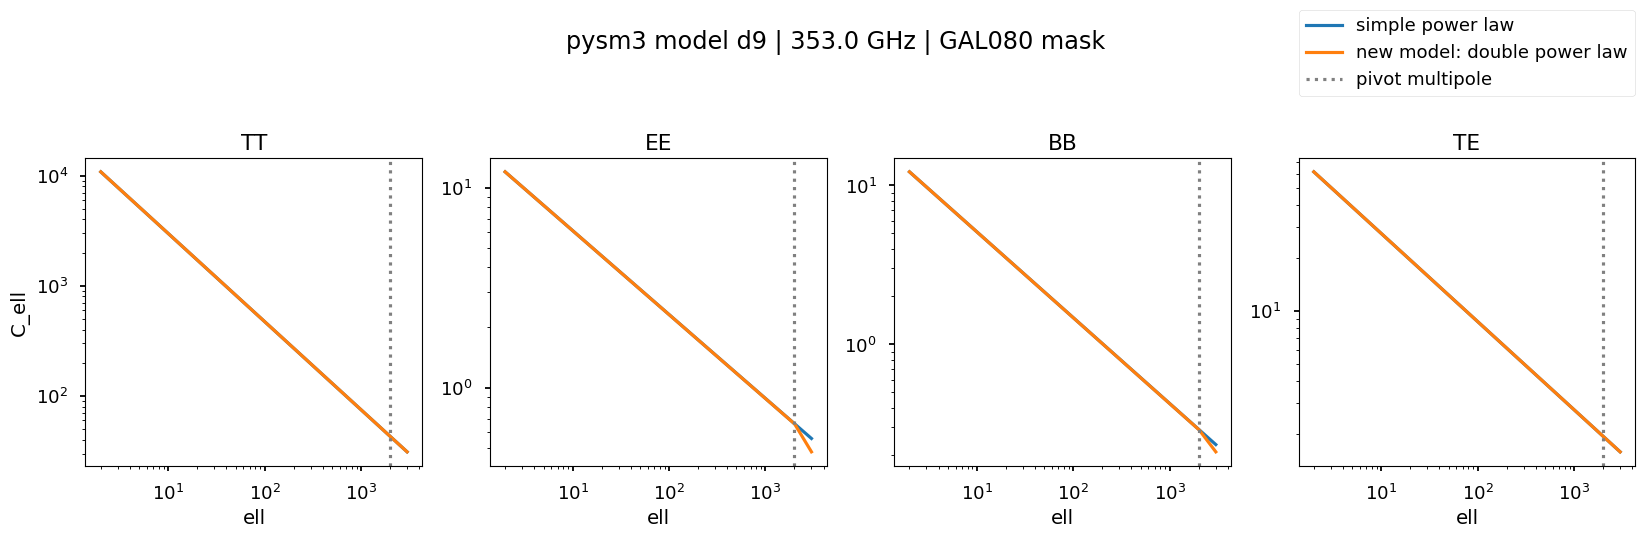

In [24]:
# Load and plot other models with previously evaluated parameters
fig, ax = plt.subplots(1,4,figsize=(20,4))
model_name = 'd9'
reffreq = 353*u.GHz

for ii, pol in enumerate(spectra_components):
    par = np.load(f"{savedir}/params{model_name}_reffreq{reffreq}_mask{maskname}.{pol}.npz")
    syncPS = fgp.PowerLaw(ell=ells, alpha=par['gamma_low'],ell_0=1,amp=par['A_low']).eval()
    syncPS_ss = PowerLawWithSmallScales(ell=ells, alpha=par['gamma_low'],ell_0=1,amp=par['A_low'], ell_pivot=par['ell_pivot'], alpha_ss=par['gamma_high'],amp_ss=par['A_high']).eval()

    ax[ii].loglog(ells, syncPS, label='simple power law')
    ax[ii].loglog(ells, syncPS_ss, label='new model: double power law')
    ax[ii].axvline(par['ell_pivot'],label='pivot multipole',linestyle='dotted',c='gray')
    # ax[ii].legend()
    ax[ii].set_xlabel('ell')
    ax[ii].set_title(f'{pol}')

ax[0].set_ylabel('C_ell')
ax[0].legend(loc=(3.6,1.2))
plt.suptitle(f"pysm3 model {model_name} | {reffreq} | {maskname} mask\n\n",fontsize='xx-large',x=.5,y=1.2)
plt.show()